In [ ]:
# Preprocess the file: replace commas with spaces
input_file = "software_graph.edgelist"
output_file = "processed_graph.edgelist"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        outfile.write(line.replace(",", " "))



In [ ]:
import networkx as nx

# Load the processed edge list
g = nx.read_edgelist("processed_graph.edgelist", create_using=nx.DiGraph, nodetype=int)

# Print the graph information
print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())
print("Nodes:", list(g.nodes()))
print("Edges:", list(g.edges()))


Number of nodes: 32987
Number of edges: 388963
Nodes: [2, 418, 426, 503, 679, 830, 930, 989, 2780, 3216, 4012, 4013, 4028, 4089, 4629, 4827, 6496, 6749, 7818, 8067, 9043, 4, 3107, 7607, 7890, 9029, 12465, 16786, 17500, 18055, 19076, 24041, 31508, 5, 558, 646, 833, 1160, 4091, 4317, 4429, 4462, 4968, 11527, 12294, 12596, 12766, 13557, 22560, 22960, 23170, 25510, 6, 1175, 1208, 1455, 2177, 4015, 4031, 4255, 4273, 5807, 7204, 7244, 7245, 7692, 8566, 8700, 8734, 9677, 12613, 31920, 7, 24948, 8, 19, 385, 667, 1234, 2185, 3392, 4001, 4863, 4866, 6647, 7473, 7492, 7788, 15170, 17848, 21105, 22076, 22204, 38522, 9, 86, 683, 3258, 4026, 7206, 8539, 8578, 12976, 13440, 27182, 39030, 11, 227, 8277, 8278, 8279, 8280, 14, 182, 344, 442, 4004, 4705, 4865, 5310, 6459, 6580, 6664, 6716, 6724, 7711, 7741, 7822, 8896, 11505, 32569, 15, 181, 305, 306, 444, 500, 545, 688, 733, 1007, 2117, 8017, 9276, 13183, 18863, 16, 4395, 7002, 17, 20, 802, 4168, 4751, 4864, 6598, 7198, 9122, 9380, 19695, 25240, 25241, 

In [ ]:
import community.community_louvain as community_louvain


# Convert to an undirected graph
g_undirected = g.to_undirected()

# Apply the Louvain method
partition = community_louvain.best_partition(g_undirected, resolution=1.0, random_state=42)

# Print the communities
#for node, community_id in partition.items():
    #print(f"Node {node} belongs to community {community_id}")

num_clusters = len(set(partition.values()))
print(f"Number of clusters: {num_clusters}")


Number of clusters: 197


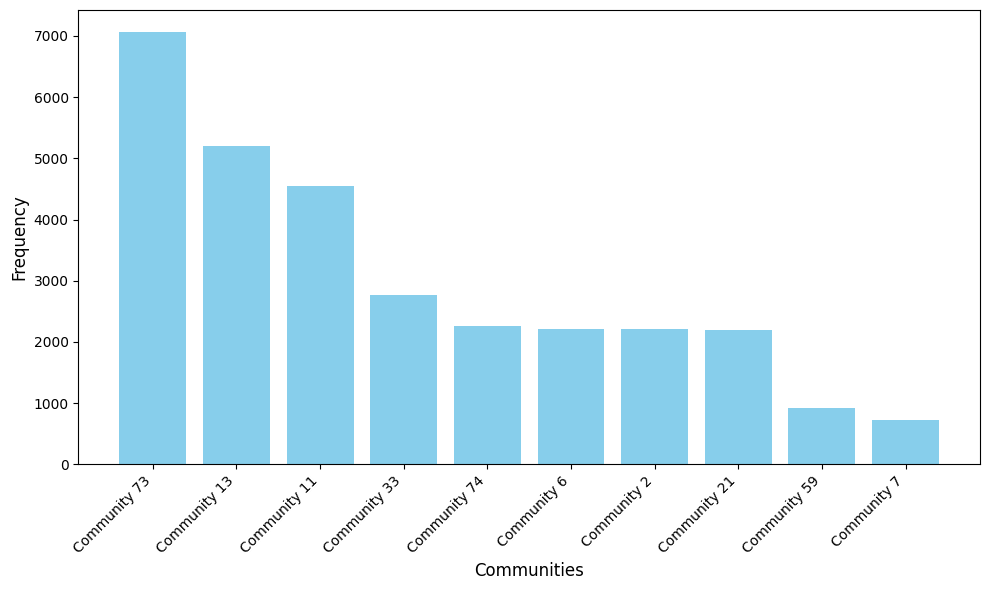

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Count the Frequency of Each Community
community_counts = Counter(partition.values())

# Step 2: Get the Top 10 Most Frequent Communities
top_10 = community_counts.most_common(10)
communities, frequencies = zip(*top_10)

# Step 3: Create the Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(communities)), frequencies, color="skyblue")
plt.xticks(range(len(communities)), [f"Community {c}" for c in communities], rotation=45, ha="right", fontsize=10)
plt.xlabel("Communities", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("", fontsize=14)
plt.tight_layout()


# Save the plot as an image

output_path = "top_10_software_communities.png"

plt.savefig(output_path, dpi=300)

plt.show()






<ipython-input-6-b143174c3e2c>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(filtered_partitions))


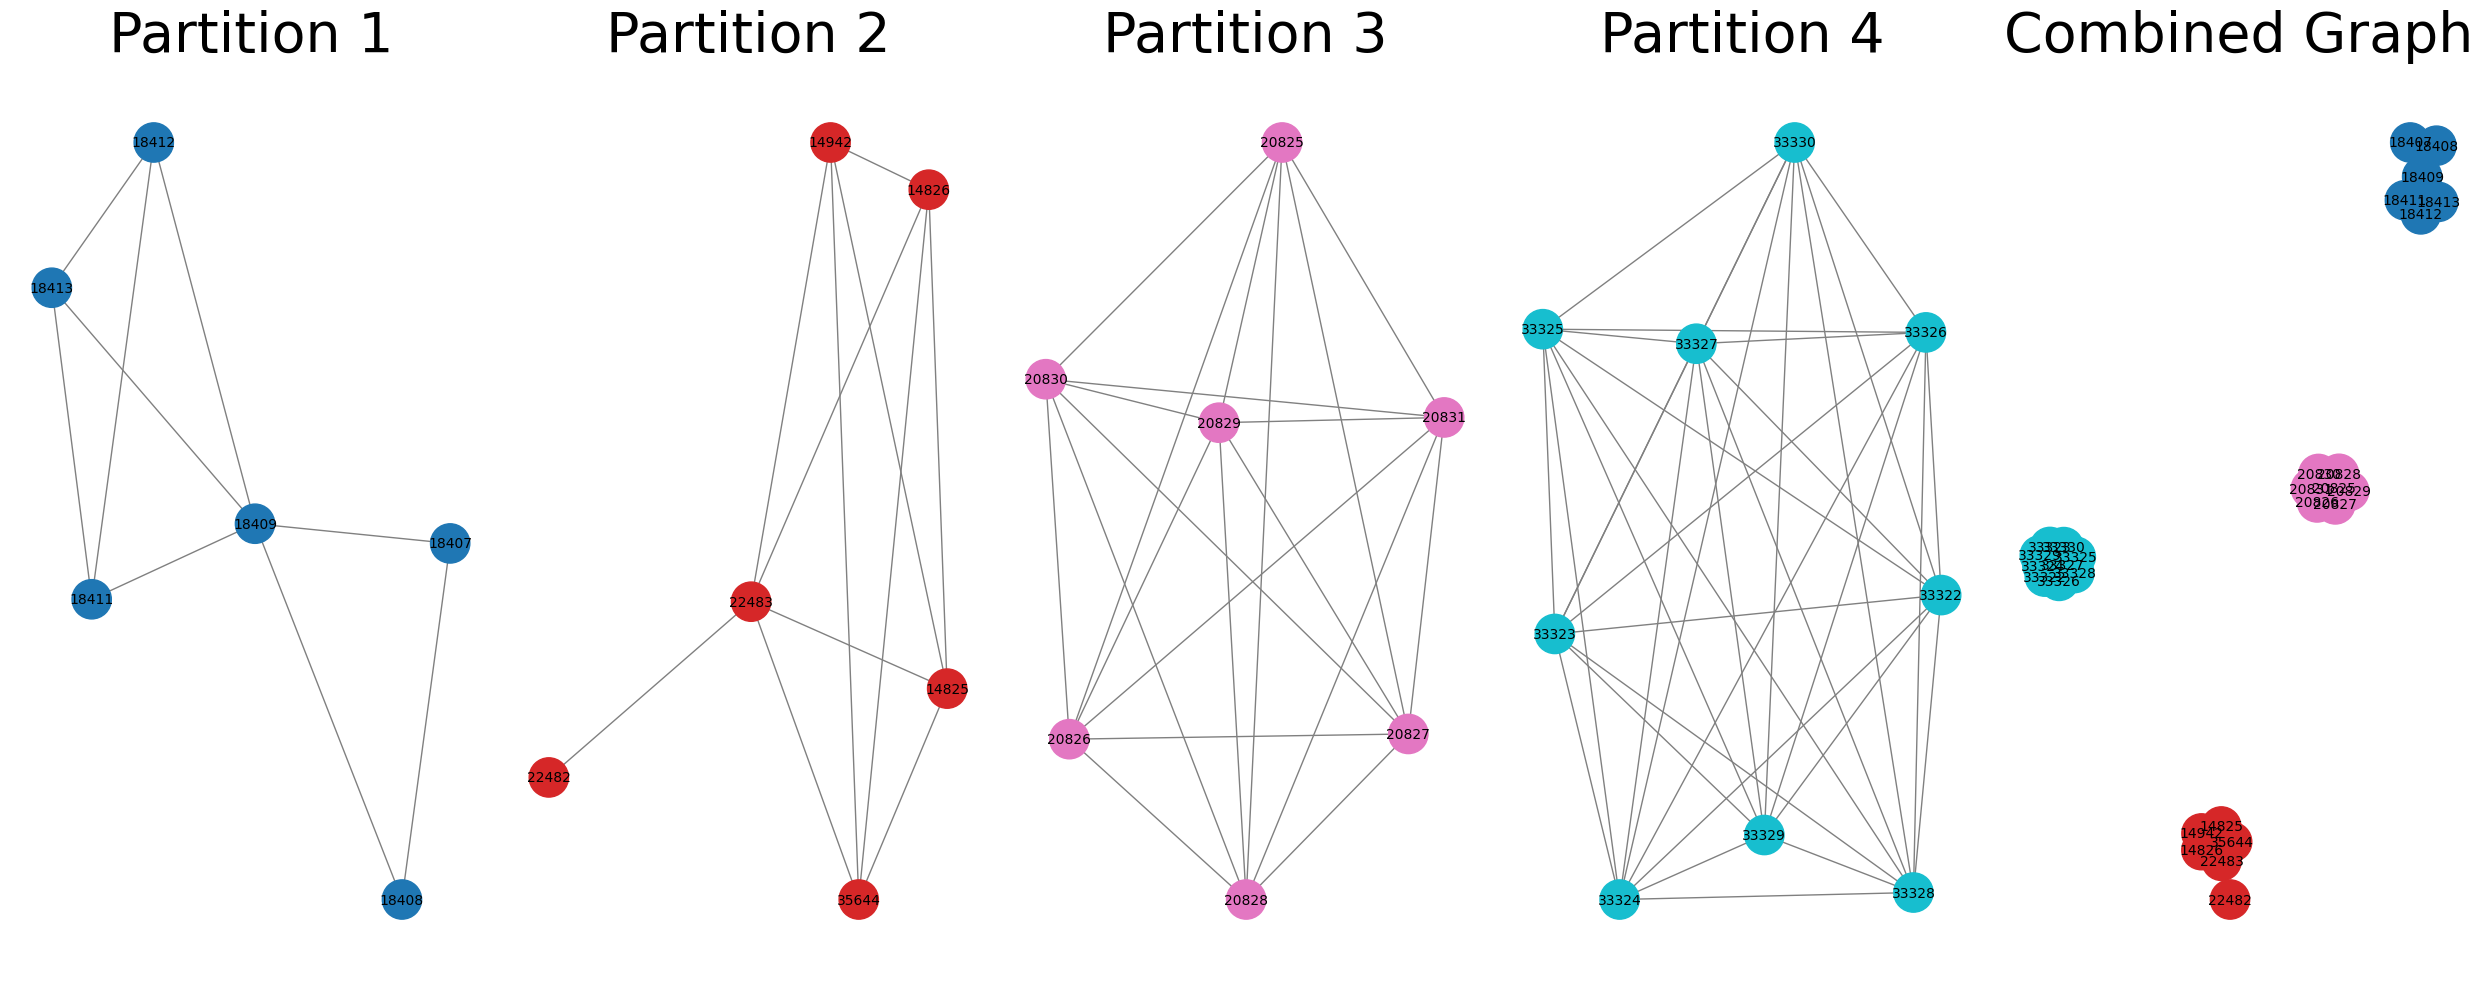

In [ ]:
from collections import defaultdict
import itertools

# Group nodes by partitions and filter by size
partition_groups = defaultdict(list)
for node, group in partition.items():
    partition_groups[group].append(node)

# Filter partitions by size (6–20 nodes) and select exactly 4 partitions
filtered_partitions = {
    key: nodes for key, nodes in sorted(partition_groups.items(), key=lambda x: len(x[1]))
    if 6 <= len(nodes) <= 20
}
filtered_partitions = dict(itertools.islice(filtered_partitions.items(), 4))

# Check if we have at least 4 partitions
if len(filtered_partitions) < 4:
    raise ValueError("Not enough partitions with size between 6 and 20 nodes.")

# Create subgraphs for individual partitions
individual_subgraphs = [
    g_undirected.subgraph(nodes) for nodes in filtered_partitions.values()
]

# Combined subgraph with filtered nodes
filtered_nodes = list(itertools.chain(*filtered_partitions.values()))
combined_subgraph = g_undirected.subgraph(filtered_nodes)

# Set up figure for side-by-side plots
fig, axes = plt.subplots(1, len(individual_subgraphs) + 1, figsize=(25, 10))

# Assign colors to partitions
partition_map = {node: idx for idx, (key, nodes) in enumerate(filtered_partitions.items()) for node in nodes}
color_map = plt.cm.get_cmap('tab10', len(filtered_partitions))
combined_node_colors = [color_map(partition_map[node]) for node in combined_subgraph.nodes()]

# Plot individual partitions
for i, (subgraph, ax) in enumerate(zip(individual_subgraphs, axes[:-1])):
    ax.set_title(f"Partition {i + 1}", fontsize=40)
    pos = nx.spring_layout(subgraph, seed=42, k=0.1)
    nx.draw(
        subgraph, pos, ax=ax,
        with_labels=True,
        node_color=[color_map(i)] * len(subgraph.nodes()),  # Single color per partition
        edge_color='gray',
        node_size=800,
        font_size=10
    )

# Plot combined graph with legend
axes[-1].set_title("Combined Graph", fontsize=40)
pos_combined = nx.spring_layout(combined_subgraph, seed=42, k=0.05)
nx.draw(
    combined_subgraph, pos_combined, ax=axes[-1],
    with_labels=True,
    node_color=combined_node_colors,
    edge_color='gray',
    node_size=800,
    font_size=10
)

# Add a legend to the combined graph
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'Partition {i + 1}',
        markersize=15,
        markerfacecolor=color_map(i)
    ) for i in range(len(filtered_partitions))
]

# Final adjustments
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.savefig("4_partitions_graph.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Extreme Multi-Label Classification for Julia DataFrame Export using PECOS (Adapted to XLinearModel)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from scipy import sparse
import os

# Step 1: Load the exported Julia DataFrame (assuming it's saved as CSV)
df = pd.read_csv("grouped_data_by_paper_id.csv")

# Step 2: Preprocess merged_msc_codes_2 and merged_software (simplified)
df['merged_msc_codes_2'] = df['merged_msc_codes_2'].apply(lambda x: [code[:2] for code in x.split(",")] if isinstance(x, str) else [])
df['merged_software'] = df['merged_software'].apply(lambda x: x.split(",") if isinstance(x, str) else [])
df["merged_software_2"] = df["merged_software"].apply(lambda x: [x] if not isinstance(x, list) else x)
df["merged_software_2"] = df["merged_software_2"].apply(lambda l:  [x for x in list(set(list(map(lambda x: partition.get(int(x)),l)))) if x is not None])
df["len_merged_software_2"] = df["merged_software_2"].apply(lambda x: len(x))
df.sort_values(by="len_merged_software_2",ascending=False)[["paper_id","merged_msc_codes_2","merged_software","merged_software_2"]]

paper_id merged_msc_codes_2  \
49016    5591694               [62]   
91612    6589448               [68]   
117086   7021634               [92]   
117085   7021633               [92]   
80319    6357750               [93]   
...          ...                ...   
171841   7749995               [68]   
141398   7361357               [68]   
136825   7299102           [11, 12]   
157119   7582895               [74]   
14861    1741969               [90]   

                                          merged_software  \
49016   [1225, 15936, 18634, 25153, 3518, 39703, 4548,...   
91612   [13532, 15430, 15431, 15432, 15433, 15434, 284...   
117086  [12253, 1283, 13656, 13828, 14646, 15114, 1693...   
117085  [10347, 10481, 11044, 11795, 12253, 12311, 136...   
80319   [1093, 12146, 1227, 12685, 1405, 14460, 21333,...   
...                                                   ...   
171841                                            [42193]   
141398                                            [39244]   
136825                                            [46580]   
157119                                            [46428]   
14861                                              [8121]   

                     merged_software_2  
49016   [2, 7, 39, 73, 44, 13, 15, 28]  
91612       [33, 6, 7, 73, 11, 44, 59]  
117086      [33, 6, 7, 73, 11, 44, 21]  
117085      [33, 2, 7, 73, 11, 13, 21]  
80319       [33, 2, 7, 74, 11, 13, 28]  
...                                ...  
171841                              []  
141398                              []  
136825                              []  
157119                              []  
14861                               []  

[178780 rows x 4 columns]

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report
# import numpy as np

# # Assuming the dataframe is already loaded as df

# # Filter out rows where "merged_software_2" is an empty list
# df = df[df["merged_software_2"].apply(len) > 0]

# # Features and target
# X = df['merged_msc_codes_2']
# y = df['merged_software_2']

# # Encode the input (merged_msc_codes_2) and output (merged_software_2) into binary format
# mlb_input = MultiLabelBinarizer()
# mlb_output = MultiLabelBinarizer()

# X_encoded = mlb_input.fit_transform(X)
# y_encoded = mlb_output.fit_transform(y)

# # Create a class weight dictionary based on label frequencies
# #y_label_counts = y_encoded.sum(axis=0)
# #class_weights = {i: 1.0 / count if count > 0 else 0.0 for i, count in enumerate(y_label_counts)}

# # Train a multi-label classifier with class weights
# clf = RandomForestClassifier(random_state=42)
# clf.fit(X_encoded, y_encoded)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# # Make predictions
# y_pred = clf.predict(X_test)

# # Ensure target names are strings for classification report
# target_names = list(map(str, mlb_output.classes_))

# # Evaluation
# print(classification_report(y_test, y_pred, target_names=target_names))

# # Save the encoders and model for later use
# import joblib

# joblib.dump(mlb_input, 'mlb_input.pkl')
# joblib.dump(mlb_output, 'mlb_output.pkl')
# joblib.dump(clf, 'multi_label_classifier.pkl')

# print("Model and encoders saved.")


In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import RandomOverSampler

# Ensure the dataframe is preloaded as `df`
# Validate that required columns exist
required_columns = ['merged_msc_codes_2', 'merged_software_2']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

# Filter rows where "merged_software_2" is not empty
df = df[df["merged_software_2"].apply(lambda x: len(x) > 0)]
df = df.reset_index(drop=True)
# Features and target
X = df['merged_msc_codes_2']
y = df['merged_software_2']

# Encode the input (merged_msc_codes_2) and output (merged_software_2) into binary format
mlb_input = MultiLabelBinarizer()
mlb_output = MultiLabelBinarizer()

X_encoded = mlb_input.fit_transform(X)
y_encoded = mlb_output.fit_transform(y)
print(f"Feature matrix shape: {X_encoded.shape}, Target matrix shape: {y_encoded.shape}")

# Step 2: Split Data
print("Step 2: Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test, train_indices, test_indices  = train_test_split(X_encoded, y_encoded,df.index.to_numpy(), test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")

# Step 3: Flatten for Oversampling
print("Step 3: Flattening multi-label targets for oversampling...")
def flatten_for_oversampling(X, y):
    rows = []
    labels = []
    indices = []
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y[i, j] == 1:
                rows.append(X[i, :])
                labels.append(j)
                indices.append(i)
    return np.array(rows), np.array(labels), np.array(indices)

X_flattened, y_flattened, indices = flatten_for_oversampling(X_train, y_train)
print(f"Flattened features shape: {X_flattened.shape}, Flattened labels shape: {y_flattened.shape}")

# Step 4: Oversample Flattened Data
print("Step 4: Applying RandomOverSampler to balance data...")
oversampler = RandomOverSampler(random_state=42)
X_resampled_flat, y_resampled_flat = oversampler.fit_resample(X_flattened, y_flattened)
print(f"Oversampled features shape: {X_resampled_flat.shape}, Oversampled labels shape: {y_resampled_flat.shape}")

# Step 5: Reconstruct Oversampled Data
print("Step 5: Reconstructing oversampled data into multi-label format...")
def unflatten_after_oversampling(X_resampled, y_resampled, indices, n_classes, original_rows):
    X_reconstructed = np.zeros((original_rows, X_resampled.shape[1]))
    y_reconstructed = np.zeros((original_rows, n_classes), dtype=int)

    for i, (x_row, label, idx) in enumerate(zip(X_resampled, y_resampled, indices)):
        X_reconstructed[idx] = x_row
        y_reconstructed[idx, label] = 1

    return X_reconstructed, y_reconstructed

X_resampled, y_resampled = unflatten_after_oversampling(
    X_resampled_flat, y_resampled_flat, indices, n_classes=y_train.shape[1], original_rows=X_train.shape[0]
)
print(f"Reconstructed feature matrix shape: {X_resampled.shape}, Reconstructed target matrix shape: {y_resampled.shape}")


# Save the encoders and model for later use
import joblib

joblib.dump(mlb_input, 'mlb_input.pkl')
joblib.dump(mlb_output, 'mlb_output.pkl')


Feature matrix shape: (169863, 63), Target matrix shape: (169863, 174)
Step 2: Splitting data into training and testing sets...
Training set size: 135890, Testing set size: 33973
Step 3: Flattening multi-label targets for oversampling...
Flattened features shape: (150442, 63), Flattened labels shape: (150442,)
Step 4: Applying RandomOverSampler to balance data...
Oversampled features shape: (5853903, 63), Oversampled labels shape: (5853903,)
Step 5: Reconstructing oversampled data into multi-label format...
Reconstructed feature matrix shape: (135890, 63), Reconstructed target matrix shape: (135890, 174)


['mlb_output.pkl']

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier


# Step 6: Train and Evaluate Models
print("Step 6: Training and evaluating models...")

# Define a function to evaluate models and save them
def evaluate_and_save_model(model, X_train, y_train, X_test, y_test, model_name, filename):
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print(f"{model_name} training completed.")

    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)
    print(f"Hamming Loss ({model_name}):", hamming_loss(y_test, y_pred))
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_test, y_pred, target_names=list(map(str, mlb_output.classes_))))

    # Save the model
    print(f"Saving {model_name}...")
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"{model_name} saved to {filename}.\n")

# Random Forest
#evaluate_and_save_model(
#    MultiOutputClassifier(RandomForestClassifier(random_state=42)),
#    X_resampled, y_resampled, X_test, y_test, "Random Forest", "random_forest_model.pkl"
#)

# XGBoost
#evaluate_and_save_model(
#    MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
#    X_resampled, y_resampled, X_test, y_test, "XGBoost", "xgboost_model.pkl"
#)

# LightGBM
evaluate_and_save_model(
    MultiOutputClassifier(LGBMClassifier(random_state=42)),
    X_resampled, y_resampled, X_test, y_test, "LightGBM", "lightgbm_model.pkl"
)




Step 6: Training and evaluating models...
Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 19949, number of negative: 115941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146803 -> initscore=-1.759902
[LightGBM] [Info] Start training from score -1.759902


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7, number of negative: 135883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000052 -> initscore=-9.873639
[LightGBM] [Info] Start training from score -9.873639


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 9259, number of negative: 126631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068136 -> initscore=-2.615681
[LightGBM] [Info] Start training from score -2.615681


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2549, number of negative: 133341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018758 -> initscore=-3.957209
[LightGBM] [Info] Start training from score -3.957209


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 20697, number of negative: 115193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.152307 -> initscore=-1.716620
[LightGBM] [Info] Start training from score -1.716620


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 36817, number of negative: 99073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270932 -> initscore=-0.989897
[LightGBM] [Info] Start training from score -0.989897


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2373, number of negative: 133517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017463 -> initscore=-4.030074
[LightGBM] [Info] Start training from score -4.030074


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 60, number of negative: 135830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000442 -> initscore=-7.724815
[LightGBM] [Info] Start training from score -7.724815


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3761, number of negative: 132129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027677 -> initscore=-3.559094
[LightGBM] [Info] Start training from score -3.559094


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 847, number of negative: 135043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006233 -> initscore=-5.071648
[LightGBM] [Info] Start training from score -5.071648


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3173, number of negative: 132717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023350 -> initscore=-3.733542
[LightGBM] [Info] Start training from score -3.733542


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5, number of negative: 135885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000037 -> initscore=-10.210126
[LightGBM] [Info] Start training from score -10.210126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 282, number of negative: 135608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002075 -> initscore=-6.175617
[LightGBM] [Info] Start training from score -6.175617


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 130, number of negative: 135760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000957 -> initscore=-6.951109
[LightGBM] [Info] Start training from score -6.951109


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 611, number of negative: 135279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004496 -> initscore=-5.399998
[LightGBM] [Info] Start training from score -5.399998


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5193, number of negative: 130697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038215 -> initscore=-3.225570
[LightGBM] [Info] Start training from score -3.225570


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 34, number of negative: 135856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000250 -> initscore=-8.292990
[LightGBM] [Info] Start training from score -8.292990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4, number of negative: 135886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000029 -> initscore=-10.433277
[LightGBM] [Info] Start training from score -10.433277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 109, number of negative: 135781
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000802 -> initscore=-7.127451
[LightGBM] [Info] Start training from score -7.127451


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 384, number of negative: 135506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002826 -> initscore=-5.866129
[LightGBM] [Info] Start training from score -5.866129


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 134, number of negative: 135756
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000986 -> initscore=-6.920775
[LightGBM] [Info] Start training from score -6.920775


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 917, number of negative: 134973
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006748 -> initscore=-4.991723
[LightGBM] [Info] Start training from score -4.991723


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 656, number of negative: 135234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004827 -> initscore=-5.328601
[LightGBM] [Info] Start training from score -5.328601


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 48, number of negative: 135842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000353 -> initscore=-7.948047
[LightGBM] [Info] Start training from score -7.948047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6, number of negative: 135884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000044 -> initscore=-10.027797
[LightGBM] [Info] Start training from score -10.027797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5, number of negative: 135885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000037 -> initscore=-10.210126
[LightGBM] [Info] Start training from score -10.210126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 9, number of negative: 135881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000066 -> initscore=-9.622310
[LightGBM] [Info] Start training from score -9.622310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 24, number of negative: 135866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000177 -> initscore=-8.641371
[LightGBM] [Info] Start training from score -8.641371


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 9, number of negative: 135881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000066 -> initscore=-9.622310
[LightGBM] [Info] Start training from score -9.622310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000074 -> initscore=-9.516942
[LightGBM] [Info] Start training from score -9.516942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4, number of negative: 135886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000029 -> initscore=-10.433277
[LightGBM] [Info] Start training from score -10.433277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4022, number of negative: 131868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029597 -> initscore=-3.490022
[LightGBM] [Info] Start training from score -3.490022


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5, number of negative: 135885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000037 -> initscore=-10.210126
[LightGBM] [Info] Start training from score -10.210126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 23548, number of negative: 112342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173287 -> initscore=-1.562507
[LightGBM] [Info] Start training from score -1.562507


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 14581, number of negative: 121309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.107300 -> initscore=-2.118622
[LightGBM] [Info] Start training from score -2.118622


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8, number of negative: 135882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000059 -> initscore=-9.740101
[LightGBM] [Info] Start training from score -9.740101


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4, number of negative: 135886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000029 -> initscore=-10.433277
[LightGBM] [Info] Start training from score -10.433277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4, number of negative: 135886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000029 -> initscore=-10.433277
[LightGBM] [Info] Start training from score -10.433277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4, number of negative: 135886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000029 -> initscore=-10.433277
[LightGBM] [Info] Start training from score -10.433277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6, number of negative: 135884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000044 -> initscore=-10.027797
[LightGBM] [Info] Start training from score -10.027797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 13, number of negative: 135877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000096 -> initscore=-9.254556
[LightGBM] [Info] Start training from score -9.254556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7, number of negative: 135883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000052 -> initscore=-9.873639
[LightGBM] [Info] Start training from score -9.873639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3, number of negative: 135887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.720967
[LightGBM] [Info] Start training from score -10.720967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 135890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2, number of negative: 135888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000015 -> initscore=-11.126439
[LightGBM] [Info] Start training from score -11.126439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1, number of negative: 135889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 135890, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000007 -> initscore=-11.819594
[LightGBM] [Info] Start training from score -11.819594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Hamming Loss (LightGBM): 0.003955981271131131

Classification Report (LightGBM):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.72      0.58      0.64      4960
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.54      0.01      0.01      2356
           7       0.00      0.00      0.00       617
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.67      0.78      0.72      5155
          12       0.00      0.00      0.00         1
          13       0.80      0.74      0.77      9224
          14       0.61      0.60      0.60       570
          15       0.00      0.00      0.00        15
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       0.00    

In [ ]:
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# MLPClassifier
evaluate_and_save_model(
    MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100, random_state=42)),
    X_resampled, y_resampled, X_test, y_test, "MLPClassifier", "mlp_classifier.pkl"
)

# Deep Learning Model with Keras
print("Training Custom Neural Network...")
input_dim = X_resampled.shape[1]
output_dim = y_resampled.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(output_dim, activation='sigmoid')  # Sigmoid for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

print("Evaluating Custom Neural Network...")
y_pred_nn = (model.predict(X_test) > 0.5).astype(int)
print(f"Hamming Loss (NN):", hamming_loss(y_test, y_pred_nn))
print(f"\nClassification Report (NN):")
print(classification_report(y_test, y_pred_nn, target_names=list(map(str, mlb_output.classes_))))

# Save the Keras model
print("Saving Custom Neural Network...")
model.save("custom_neural_network_model.h5")
print("Custom Neural Network saved to custom_neural_network_model.h5.\n")

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd


# Step 2: Split Data
print("Step 2: Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")

# Step 3: Flatten for Oversampling
print("Step 3: Flattening multi-label targets for oversampling...")
def flatten_for_oversampling(X, y):
    rows = []
    labels = []
    indices = []
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y[i, j] == 1:
                rows.append(X[i, :])
                labels.append(j)
                indices.append(i)
    return np.array(rows), np.array(labels), np.array(indices)

X_flattened, y_flattened, indices = flatten_for_oversampling(X_train, y_train)
print(f"Flattened features shape: {X_flattened.shape}, Flattened labels shape: {y_flattened.shape}")

# Step 4: Oversample Flattened Data
print("Step 4: Applying RandomOverSampler to balance data...")
oversampler = RandomOverSampler(random_state=42)
X_resampled_flat, y_resampled_flat = oversampler.fit_resample(X_flattened, y_flattened)
print(f"Oversampled features shape: {X_resampled_flat.shape}, Oversampled labels shape: {y_resampled_flat.shape}")

# Step 5: Reconstruct Oversampled Data
print("Step 5: Reconstructing oversampled data into multi-label format...")
def unflatten_after_oversampling(X_resampled, y_resampled, indices, n_classes, original_rows):
    X_reconstructed = np.zeros((original_rows, X_resampled.shape[1]))
    y_reconstructed = np.zeros((original_rows, n_classes), dtype=int)

    for i, (x_row, label, idx) in enumerate(zip(X_resampled, y_resampled, indices)):
        X_reconstructed[idx] = x_row
        y_reconstructed[idx, label] = 1

    return X_reconstructed, y_reconstructed

X_resampled, y_resampled = unflatten_after_oversampling(
    X_resampled_flat, y_resampled_flat, indices, n_classes=y_train.shape[1], original_rows=X_train.shape[0]
)
print(f"Reconstructed feature matrix shape: {X_resampled.shape}, Reconstructed target matrix shape: {y_resampled.shape}")

# Step 6: Train and Evaluate Models
print("Step 6: Training and evaluating models...")

# Function to evaluate models
def evaluate_model(model, model_name):
    print(f"Training {model_name}...")
    model.fit(X_resampled, y_resampled)
    print(f"{model_name} training completed.")

    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)
    print(f"Hamming Loss ({model_name}):", hamming_loss(y_test, y_pred))
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_test, y_pred, target_names=list(map(str, mlb_output.classes_))))
    print(f"{model_name} evaluation completed.\n")

# Binary Relevance
binary_relevance_model = BinaryRelevance(classifier=RandomForestClassifier(random_state=42))
evaluate_model(binary_relevance_model, "Binary Relevance")

# Classifier Chain
classifier_chain_model = ClassifierChain(classifier=RandomForestClassifier(random_state=42))
evaluate_model(classifier_chain_model, "Classifier Chain")

# Label Powerset
label_powerset_model = LabelPowerset(classifier=RandomForestClassifier(random_state=42))
evaluate_model(label_powerset_model, "Label Powerset")

ModuleNotFoundError: No module named 'skmultilearn'

In [ ]:
from collections import defaultdict
import pandas as pd
import networkx as nx
from community import community_louvain
from IPython.display import display

# Step 1: Load the exported Julia DataFrame (assuming it's saved as CSV)
software_count = pd.read_csv("software_citation_count.csv")

# Step 1: Assuming software_count DataFrame is already loaded
# Example format:
# software_count = pd.DataFrame({
#     "id": [2, 4, 5, 6, 7],
#     "articles_count": [106, 9, 127, 37, 4]
# })

software_count.set_index("id", inplace=True)

# Calculate citation weight ratio for each software
total_articles = software_count["articles_count"].sum()
software_count["citation_weight_ratio"] = software_count["articles_count"] / total_articles

# Step 2: Assuming `partition` exists
# Example format (generated from Louvain method):
# partition = {2: 1, 4: 1, 5: 2, 6: 2, 7: 1}

# Step 3: Group software by community
community_software = defaultdict(list)
for software_id, community_id in partition.items():
    community_software[community_id].append(software_id)

# Step 4: Compute top 5 software by citation weight ratio per community
top_software_per_community = {}
for community_id, software_list in community_software.items():
    # Filter software that exists in software_count
    filtered_software = software_count.loc[software_count.index.intersection(software_list)]
    sorted_ratios = filtered_software.sort_values(by="citation_weight_ratio", ascending=False)
    top_software_per_community[community_id] = sorted_ratios.head(5)

# Prepare results for display
result_data = []
for community_id, top_software in top_software_per_community.items():
    for software_id, row in top_software.iterrows():
        result_data.append({
            "Community": community_id,
            "Software": software_id,
            "Citation Weight Ratio": row["citation_weight_ratio"]
        })

top_software_df = pd.DataFrame(result_data)

# Step 5: Display results in Google Colab
display(top_software_df)


Community  Software  Citation Weight Ratio
0           13       558               0.024194
1           13      4968               0.006103
2           13      4112               0.003030
3           13      4012               0.002971
4           13       503               0.002933
..         ...       ...                    ...
516         52     38699               0.000002
517         85     38885               0.000003
518         85     38886               0.000002
519         97     39216               0.000002
520         97     39217               0.000002

[521 rows x 3 columns]

In [ ]:
import pickle
from scipy.sparse import csr_matrix
from sklearn.metrics import hamming_loss, classification_report
from collections import defaultdict


# Step 1: Load the saved model
print("Loading the saved pickle model...")
with open('lightgbm_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print("Model loaded successfully.")


predicted_communities = loaded_model.predict(X_test.astype(np.float32))
print("Prediction completed.")



Loading the saved pickle model...
Model loaded successfully.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Prediction completed.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
predicted_communities_array = predicted_communities.toarray() if hasattr(predicted_communities, 'toarray') else predicted_communities

In [ ]:
# Step 5: Decode predicted communities into software community labels
predicted_community_labels = [list(tup) for tup in mlb_output.inverse_transform(predicted_communities_array)]

In [ ]:
df_final_test=df.iloc[test_indices]
df_final_test["Predicted Software Communities"]=pd.Series(predicted_community_labels)

<ipython-input-58-a5fa84d2c183>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_test["Predicted Software Communities"]=pd.Series(predicted_community_labels)


In [ ]:
df_final_test.head()

paper_id merged_msc_codes_2 merged_software merged_software_2  \
61464    5996427               [17]    [1048, 8644]              [74]   
64341    6055684           [68, 90]         [18811]               [2]   
1109      194075       [62, 68, 05]         [14176]              [30]   
133750   7330375               [68]          [2934]              [59]   
168471   7819050           [65, 76]   [30277, 5863]           [73, 6]   

        len_merged_software_2 Predicted Software Communities  
61464                       1                            NaN  
64341                       1                            NaN  
1109                        1                           [13]  
133750                      1                            NaN  
168471                      2                            NaN

In [ ]:
community_to_software = defaultdict(list)
for software_id, community_id in partition.items():
    community_to_software[community_id].append(software_id)

# Convert defaultdict to a standard dict for display or further use
community_to_software = dict(community_to_software)